# rewrite data under zarr format with standard layout

In [2]:
import os, sys
import numpy as np
import dask
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from scipy.signal import welch

from mitequinox.utils import *

In [1]:
from dask_jobqueue import PBSCluster
# for heavy processing:
cluster = PBSCluster(cores=6, processes=6, walltime='12:00:00')
w = cluster.scale(6*40)
# for zonal averaging post processing:
#cluster = PBSCluster(cores=12, processes=12, walltime='12:00:00')
#w = cluster.scale(40*12)
#w = cluster.scale(10*12)

/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/dask_jobqueue/config.py:12: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/distributed/deploy/local.py:138: UserWarning: diagnostics_port has been deprecated. Please use `dashboard_address=` instead
  "diagnostics_port has been deprecated. "


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
cluster

In [8]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client


---

## notes for eNATL60 team

zarr archive for v does not contain latitude information

nav_lon, nav_lat are not useful names in the same archives

nav_lon, nav_lat are masked over land, this is not practical for plotting purposes

chunking is too small spatially


---

# browse datasets

In [16]:
ds_U = xr.open_zarr(enatl60_data_dir+'zarr/eNATL60-BLBT02-SSU-1h')
ds_V = xr.open_zarr(enatl60_data_dir+'zarr/eNATL60-BLBT02-SSV-1h')

print(ds_U)
print(ds_V)

<xarray.Dataset>
Dimensions:       (time_counter: 8760, x: 8354, y: 4729)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2009-07-01T00:30:00 ... 2010-06-30T23:30:00
Dimensions without coordinates: x, y
Data variables:
    nav_lat       (y, x) float32 dask.array<shape=(4729, 8354), chunksize=(296, 1045)>
    nav_lon       (y, x) float32 dask.array<shape=(4729, 8354), chunksize=(296, 1045)>
    sozocrtx      (time_counter, y, x) float32 dask.array<shape=(8760, 4729, 8354), chunksize=(24, 120, 120)>
Attributes:
    Conventions:  CF-1.6
    NCO:          4.4.6
    TimeStamp:    08/01/2019 09:34:23 +0100
    description:  ocean U grid variables
    file_name:    eNATL60-BLBT02_1h_20090630_20090704_gridU-2D_20090701-20090...
    history:      Fri May 24 23:57:12 2019: ncks -O -F -v sozocrtx /store/CT1...
    ibegin:       0
    jbegin:       0
    name:         /scratch/tmp/3746956/eNATL60-BLBT02_1h_20090630_20090704_gr...
    ni:           8354
    nj:           9
    timeStam

array(0.74210024, dtype=float32)

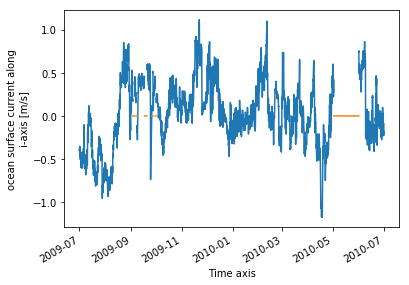

In [35]:
u = ds_U.sozocrtx.isel(x=2000,y=2000)
u.plot()
u.fillna(0.).where(np.isnan(u)).plot()
u.sel(time_counter='2010-06-01T00:30:00').values

In [37]:
u = ds_U.sozocrtx.isel(x=2000,y=2000)
u = u.where(np.isnan(u),drop=True)

In [38]:
u

<xarray.DataArray 'sozocrtx' (time_counter: 912)>
dask.array<shape=(912,), dtype=float32, chunksize=(24,)>
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2009-09-03T00:30:00 ... 2010-05-31T23:30:00
Attributes:
    cell_methods:        time: mean (interval: 40 s)
    coordinates:         nav_lon nav_lat time_centered
    interval_operation:  40 s
    interval_write:      1 h
    long_name:           ocean surface current along i-axis
    online_operation:    average
    units:               m/s

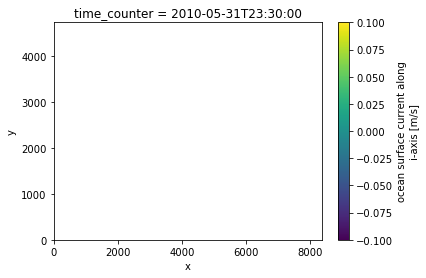

In [39]:
ds_U.sozocrtx.sel(time_counter='2010-05-31T23:30:00').plot()

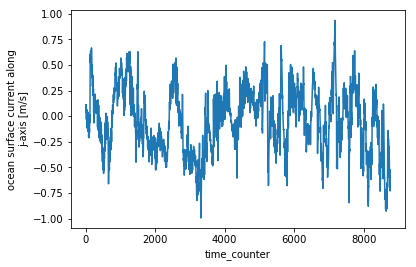

In [23]:
v = ds_V.somecrty.isel(x=2000,y=2000)
v.plot()
v.fillna(0.).where(np.isnan(v)).plot()


!! Note: `ds_V` has `nav_lon` but not `nav_lat`

In [6]:
ds_V = ds_V.drop('nav_lon')

In [7]:
print(ds_U.time_counter[0].values, ds_U.time_counter[-1].values)

2009-07-01T00:30:00.000000000 2010-06-30T23:30:00.000000000


In [8]:
# if too many files opened error, do client.restart()
Nmonth=730
for imonth in range(6,12):
    islice = slice(imonth*Nmonth,(imonth+1)*Nmonth)
    ds = xr.merge([ds_U.isel(time_counter=islice), 
                   ds_V.isel(time_counter=islice)])
    ds = ds.rename({'time_counter':'time', 'nav_lon':'lon', 'nav_lat':'lat',
                    'sozocrtx': 'SSU', 'somecrty': 'SSV'})
    print(ds.time[0].values, ds.time[-1].values)
    ds = ds.set_coords(['lon','lat'])
    ds = ds.chunk({'x': 480, 'y': 480, 'time': None})
    #
    del ds['lon'].encoding['chunks'], ds['lat'].encoding['chunks']
    del ds['SSU'].encoding['chunks'], ds['SSV'].encoding['chunks']
    ds.SSU.attrs.pop('coordinates')
    ds.SSV.attrs.pop('coordinates')
    #
    ds.to_zarr(work_data_dir+'enatl60/SSUV_m%02d.zarr'%imonth, mode='w')
    print('month %d done'%imonth)

2009-12-30T12:30:00.000000000 2010-01-29T21:30:00.000000000
month 6 done
2010-01-29T22:30:00.000000000 2010-03-01T07:30:00.000000000
month 7 done
2010-03-01T08:30:00.000000000 2010-03-31T17:30:00.000000000
month 8 done
2010-03-31T18:30:00.000000000 2010-05-01T03:30:00.000000000
month 9 done
2010-05-01T04:30:00.000000000 2010-05-31T13:30:00.000000000
month 10 done
2010-05-31T14:30:00.000000000 2010-06-30T23:30:00.000000000
month 11 done


---

## load rechunked data

In [5]:
ds = xr.concat([xr.open_zarr(work_data_dir+'enatl60/SSUV_m%02d.zarr'%imonth)
                for imonth in range(12)], dim='time')

In [6]:
# spatial strides for decimation
dij=2 # 2 should fit
# spatial subsetting
ds = ds.isel(x=slice(0,None,dij), y=slice(0,None,dij))
#ds = ds.chunk({'x':240,'y':240})
ds = ds.chunk({'x':120,'y':120})
ds['SSUV'] = ds['SSU'].fillna(0.) + 1j * ds['SSV'].fillna(0.)
ds = ds.drop(['SSU','SSV'])
ds = ds.chunk({'time':None})
ds

<xarray.Dataset>
Dimensions:  (time: 8760, x: 4177, y: 2365)
Coordinates:
    lat      (y, x) float32 dask.array<shape=(2365, 4177), chunksize=(120, 120)>
    lon      (y, x) float32 dask.array<shape=(2365, 4177), chunksize=(120, 120)>
  * time     (time) datetime64[ns] 2009-07-01T00:30:00 ... 2010-06-30T23:30:00
Dimensions without coordinates: x, y
Data variables:
    SSUV     (time, y, x) complex64 dask.array<shape=(8760, 2365, 4177), chunksize=(8760, 120, 120)>

In [7]:
ds = ds.persist()

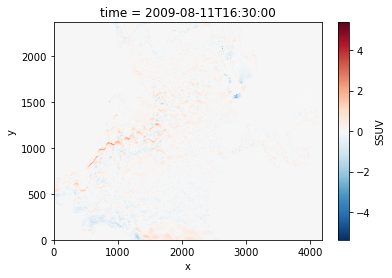

In [8]:
np.real(ds.SSUV.isel(time=1000)).plot()

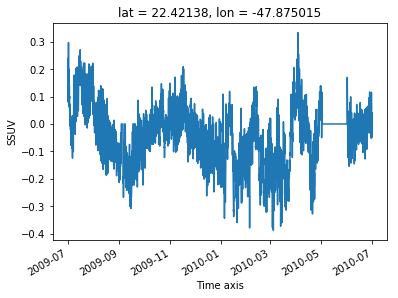

In [9]:
np.real(ds.SSUV.isel(x=1500,y=500)).plot()

---

## store rms and std

In [9]:
ds_out = np.real(ds.SSUV.mean('time')).rename('SSUV_mean').to_dataset().persist()

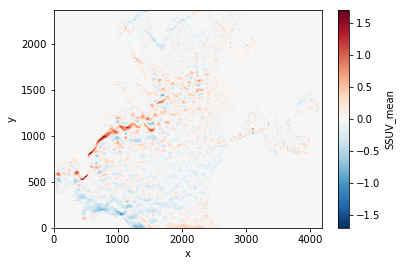

In [10]:
np.real(ds_out.SSUV_mean).plot()

In [11]:
ds_out['SSU_rms'] = (np.real(ds.SSUV)**2).mean('time').rename('SSU_rms')
ds_out['SSV_rms'] = (np.imag(ds.SSUV)**2).mean('time').rename('SSV_rms')
ds_out['SSU_std'] = (np.real(ds.SSUV-ds_out.SSUV_mean)**2).mean('time').rename('SSU_std')
ds_out['SSV_std'] = (np.imag(ds.SSUV-ds_out.SSUV_mean)**2).mean('time').rename('SSV_std')

ds_out

<xarray.Dataset>
Dimensions:    (x: 4177, y: 2365)
Coordinates:
    lat        (y, x) float32 dask.array<shape=(2365, 4177), chunksize=(120, 120)>
    lon        (y, x) float32 dask.array<shape=(2365, 4177), chunksize=(120, 120)>
Dimensions without coordinates: x, y
Data variables:
    SSUV_mean  (y, x) float32 dask.array<shape=(2365, 4177), chunksize=(120, 120)>
    SSU_rms    (y, x) float32 dask.array<shape=(2365, 4177), chunksize=(120, 120)>
    SSV_rms    (y, x) float32 dask.array<shape=(2365, 4177), chunksize=(120, 120)>
    SSU_std    (y, x) float32 dask.array<shape=(2365, 4177), chunksize=(120, 120)>
    SSV_std    (y, x) float32 dask.array<shape=(2365, 4177), chunksize=(120, 120)>

In [14]:
del ds_out.lon.encoding['chunks'], ds_out.lat.encoding['chunks']
( ds_out.chunk({'x':480, 'y': 480})
        .to_zarr(work_data_dir+'enatl60/SSUV_stats.zarr', mode='w') )

---

## spectral calculation

In [10]:
# utility functions in order to compute frequency spectra
def _get_E(x, ufunc=True, **kwargs):
    ax = -1 if ufunc else 0
    #
    dkwargs = {'window': 'hann', 'return_onesided': False, 
               'detrend': 'linear', 'scaling': 'density'}
    dkwargs.update(kwargs)
    # 50% overlap by default
    f, E = welch(x, fs=24., axis=ax, **dkwargs)
    #
    if ufunc:
        return E
    else:
        return f, E

def get_E(v, f=None, **kwargs):
    #v = v.chunk({'time': len(v.time)})
    if 'nperseg' in kwargs:
        Nb = kwargs['nperseg']
    else:
        Nb = 60*24
        kwargs['nperseg']= Nb
    if f is None:
        f, E = _get_E(v.values, ufunc=False, **kwargs)
        return f, E
    else:
        E = xr.apply_ufunc(_get_E, v,
                    dask='parallelized', output_dtypes=[np.float64],
                    input_core_dims=[['time']],
                    output_core_dims=[['freq_time']],
                    output_sizes={'freq_time': Nb}, kwargs=kwargs)
        return E.assign_coords(freq_time=f).sortby('freq_time')

In [11]:
overwrite=True

# spectral computation
# need to run once to get frequency line
f, E = get_E(ds['SSUV'].isel(x=2,y=2))

Nx=120*4 # 120*8 leads to workers memory blow ups
ix, idx = 0, 0
while ix<ds.x.size:
    #
    E = get_E(ds['SSUV'].isel(x=slice(ix,min(ix+Nx,ds.x.size))), f=f)

    # store
    E = E.to_dataset()
    del E.lon.encoding['chunks'], E.lat.encoding['chunks']
    Efile = work_data_dir+'enatl60/E_UV_x%02d.zarr'%idx
    if not os.path.isdir(Efile) or overwrite:
        %time E.to_zarr(Efile, mode='w')
        print('--- idx=%02d, ix=%d,%d done'%(idx,ix,ix+Nx))
    else:
        print('--- allready computed')
    ix+=Nx
    idx+=1
                

/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/dask/array/blockwise.py:210: UserWarning: The da.atop function has moved to da.blockwise
  warnings.warn("The da.atop function has moved to da.blockwise")


CPU times: user 17.2 s, sys: 1.56 s, total: 18.8 s
Wall time: 1min 32s
--- idx=00, ix=0,480 done
CPU times: user 7.04 s, sys: 653 ms, total: 7.69 s
Wall time: 36.6 s
--- idx=01, ix=480,960 done
CPU times: user 7.77 s, sys: 730 ms, total: 8.5 s
Wall time: 39.9 s
--- idx=02, ix=960,1440 done
CPU times: user 10.9 s, sys: 900 ms, total: 11.8 s
Wall time: 50.8 s
--- idx=03, ix=1440,1920 done
CPU times: user 6.91 s, sys: 547 ms, total: 7.46 s
Wall time: 37 s
--- idx=04, ix=1920,2400 done
CPU times: user 6.43 s, sys: 599 ms, total: 7.03 s
Wall time: 34.6 s
--- idx=05, ix=2400,2880 done
CPU times: user 9.03 s, sys: 760 ms, total: 9.79 s
Wall time: 41.6 s
--- idx=06, ix=2880,3360 done
CPU times: user 6.33 s, sys: 539 ms, total: 6.87 s
Wall time: 34.3 s
--- idx=07, ix=3360,3840 done
CPU times: user 6.42 s, sys: 588 ms, total: 7.01 s
Wall time: 33.4 s
--- idx=08, ix=3840,4320 done


---

## inspect result

In [13]:
def load_E(stack=False):
    ds = xr.concat([xr.open_zarr(work_data_dir+'enatl60/E_UV_x%02d.zarr'%idx) 
                for idx in range(9)],dim='x')
    ds = ds.drop(['lon','lat'])
    #
    grd = load_enatl60_grid()
    grd = grd.isel(x=slice(None,None,2),y=slice(None,None,2))
    grd = grd.chunk({'x':240, 'y':240})
    grd['depth'] = (grd.gdept_0*grd.tmask).max('z')
    grd = grd.isel(z=0)
    #
    ds = (ds.assign_coords(mask=grd.umask*grd.vmask,
                          lon=grd.glamt, lat=grd.gphit,
                          depth=grd.depth, 
                          dA=grd.e1t*grd.e2t*grd.umask*grd.vmask))
    if stack:
        ds = ds.stack(points=['x','y'])
        #.chunk({'points':2*1e4})
    return ds.persist()

ds = load_E(stack=True)

In [14]:
ds = ds.assign_coords(mask_depth = ds.mask.where(ds.depth>500))
#
bounds = {'lon': [-97, 41],'lat':[7, 62]}
ds = ds.assign_coords(mask_depth_bounds = ds.mask_depth.where( (ds.lon>=bounds['lon'][0]) 
                                                         & (ds.lon<=bounds['lon'][1]) 
                                                         & (ds.lat>=bounds['lat'][0]) 
                                                         & (ds.lat<=bounds['lat'][1]) , 
                                                         other=0) )

In [15]:
print('Data size = %.1f GB' %(ds.nbytes/1e9))
ds

Data size = 114.2 GB


<xarray.Dataset>
Dimensions:            (freq_time: 1440, points: 9878605)
Coordinates:
  * freq_time          (freq_time) float64 -12.0 -11.98 -11.97 ... 11.97 11.98
    lon                (points) float32 dask.array<shape=(9878605,), chunksize=(56760,)>
    lat                (points) float32 dask.array<shape=(9878605,), chunksize=(56760,)>
    z                  float32 dask.array<shape=(), chunksize=()>
    dA                 (points) float64 dask.array<shape=(9878605,), chunksize=(56760,)>
    depth              (points) float32 dask.array<shape=(9878605,), chunksize=(56760,)>
    mask               (points) int8 dask.array<shape=(9878605,), chunksize=(56760,)>
  * points             (points) MultiIndex
  - x                  (points) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
  - y                  (points) int64 0 1 2 3 4 5 6 7 ... 23 24 25 26 27 28 29
    mask_depth         (points) float64 dask.array<shape=(9878605,), chunksize=(56760,)>
    mask_depth_bounds  (points) fl

---

### spatial average

involves stacking points

In [11]:
#ds = ds.stack(points=['x','y']).chunks({'points':5*1e5})

In [16]:
ds = ds.persist()

In [17]:
def mean_xy(v):
    return (v * v.dA*v.mask_depth_bounds).sum(dim=['points']) / (v.dA*v.mask_depth_bounds).sum()

In [18]:
# global average, ignore metrics
ds_out = (ds.SSUV*ds.mask_depth_bounds).mean(dim=['points'], skipna=True).rename('E_global_noA').to_dataset()
ds_out['E_global'] = mean_xy(ds.SSUV).rename('E_global')

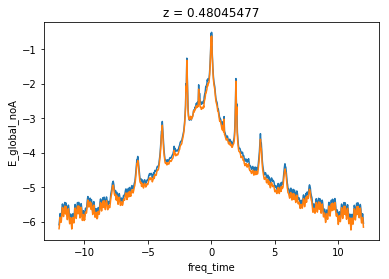

In [19]:
fig, ax = plt.subplots(1,1)
np.log10(ds_out.E_global).plot(ax=ax)
np.log10(ds_out.E_global_noA).plot(ax=ax)

In [20]:
# zonal average
lat_bins = np.arange(0.,65.,1.)
latc = (lat_bins[1:]+lat_bins[:-1])*.5
def zonal_average(v):
    #v_stacked = v.stack(points=['x','y'])
    dA = v.dA*v.mask_depth_bounds
    out = (v*dA).groupby_bins(ds.lat,lat_bins).sum('points') \
            / dA.groupby_bins(ds.lat,lat_bins).sum('points')
    #out = out.rename({'':''})
    return out

ds_out['E_zav'] = zonal_average(ds.SSUV).rename('E_zav') #.assign_coords(lat_bins=latc)

In [21]:
ds_out

<xarray.Dataset>
Dimensions:       (freq_time: 1440, lat_bins: 64)
Coordinates:
  * freq_time     (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
    z             float32 dask.array<shape=(), chunksize=()>
  * lat_bins      (lat_bins) object (0.0, 1.0] (1.0, 2.0] ... (63.0, 64.0]
Data variables:
    E_global_noA  (freq_time) float64 dask.array<shape=(1440,), chunksize=(1440,)>
    E_global      (freq_time) float64 dask.array<shape=(1440,), chunksize=(1440,)>
    E_zav         (freq_time, lat_bins) float64 dask.array<shape=(1440, 64), chunksize=(1440, 7)>

In [22]:
ds_out = ds_out.persist()

In [23]:
ds_out = ds_out.drop(['lat_bins','z'])
ds_out = ds_out.assign_coords(lat_bins=latc)
ds_out = ds_out.chunk({'lat_bins':None})
ds_out = ds_out.drop('z')

In [24]:
ds_out

<xarray.Dataset>
Dimensions:       (freq_time: 1440, lat_bins: 64)
Coordinates:
  * freq_time     (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * lat_bins      (lat_bins) float64 0.5 1.5 2.5 3.5 4.5 ... 60.5 61.5 62.5 63.5
Data variables:
    E_global_noA  (freq_time) float64 dask.array<shape=(1440,), chunksize=(1440,)>
    E_global      (freq_time) float64 dask.array<shape=(1440,), chunksize=(1440,)>
    E_zav         (freq_time, lat_bins) float64 dask.array<shape=(1440, 64), chunksize=(1440, 64)>

In [26]:
ds_out.to_zarr(work_data_dir+'enatl60/E_UV_stats.zarr', mode='w')

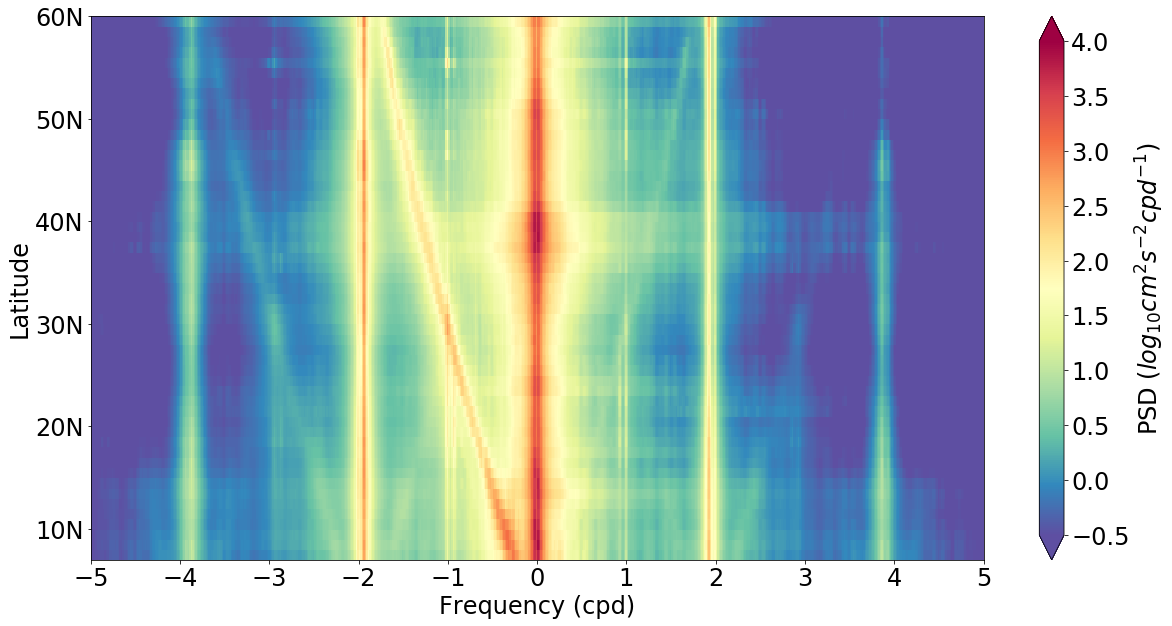

In [27]:
plt.figure(figsize=(20,10))
ax = plt.subplot(1,1,1)

#np.log10(lE_zav*1e4).plot(x='freq_time', y='lat_bins', 
cax = np.log10(ds_out.E_zav*1e4).plot(x='freq_time', y='lat_bins', 
                                      add_colorbar=False,
                                      vmin=-.5, vmax=4., 
                                      cmap='Spectral_r', ax=ax)

#cax = np.log10(ds_out.E_zav*1e4).plot(x='freq_time', y='lat_bins',
#                                      vmin=-.5, vmax=4., 
#                                      cmap='Spectral_r')
# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=24)
cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=24)

# x,y ticks
#ax.set_xticks([-12., -10., -8., -6., -4., -2., 0, 2., 4., 6., 8., 10., 12.])
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
#ax.set_xlim(-12., 12.)
ax.set_xlim(-5., 5.)
ax.set_ylim(7., 60.)
ax.set_yticks([10., 20., 30, 40., 50, 60.])
ax.set_yticklabels(['10N','20N','30N','40N','50N','60N'])
ax.set_ylabel('Latitude',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)

#plt.get_cmap('RdYlBu_r'))
# x='freq_time', y='lat_bins', vmin=-.5,vmax=4.

---

### maps

In [33]:
del ds, ds_out

In [37]:
ds = load_E()
ds

<xarray.Dataset>
Dimensions:    (freq_time: 1440, x: 4177, y: 2365)
Coordinates:
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
    lon        (y, x) float32 dask.array<shape=(2365, 4177), chunksize=(240, 240)>
    lat        (y, x) float32 dask.array<shape=(2365, 4177), chunksize=(240, 240)>
    z          float32 dask.array<shape=(), chunksize=()>
    dA         (y, x) float64 dask.array<shape=(2365, 4177), chunksize=(240, 240)>
    depth      (y, x) float32 dask.array<shape=(2365, 4177), chunksize=(240, 240)>
    mask       (y, x) int8 dask.array<shape=(2365, 4177), chunksize=(240, 240)>
Dimensions without coordinates: x, y
Data variables:
    SSUV       (y, x, freq_time) float64 dask.array<shape=(2365, 4177, 1440), chunksize=(240, 240, 1440)>

In [38]:
# global map of semi-diurnal energy
df = ds.freq_time[1]-ds.freq_time[0]
E2 = ds.SSUV.where(abs(abs(ds.freq_time)-2.)<.1, other=0.).sum(dim='freq_time')*df
E2.persist()
#E2 = E2.where(E2>0)
print(E2)

<xarray.DataArray (y: 2365, x: 4177)>
dask.array<shape=(2365, 4177), dtype=float64, chunksize=(240, 240)>
Coordinates:
    lon      (y, x) float32 dask.array<shape=(2365, 4177), chunksize=(240, 240)>
    lat      (y, x) float32 dask.array<shape=(2365, 4177), chunksize=(240, 240)>
    z        float32 dask.array<shape=(), chunksize=()>
    dA       (y, x) float64 dask.array<shape=(2365, 4177), chunksize=(240, 240)>
    depth    (y, x) float32 dask.array<shape=(2365, 4177), chunksize=(240, 240)>
    mask     (y, x) int8 dask.array<shape=(2365, 4177), chunksize=(240, 240)>
Dimensions without coordinates: y, x


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


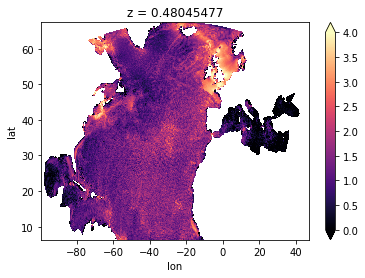

distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


In [41]:
np.log10(E2*1e4).plot(x='lon',y='lat', vmin=0., vmax=4., cmap='magma')

In [42]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client


---

## various plots

In [9]:
ds_plt = ds.isel(x=slice(None,None,4), y=slice(None,None,4), time=0)
ds_plt

<xarray.Dataset>
Dimensions:  (x: 2089, y: 1183)
Coordinates:
    time     datetime64[ns] 2009-07-01T00:30:00
    lat      (y, x) float32 dask.array<shape=(1183, 2089), chunksize=(74, 262)>
    lon      (y, x) float32 dask.array<shape=(1183, 2089), chunksize=(74, 262)>
Dimensions without coordinates: x, y
Data variables:
    SSU      (y, x) float32 dask.array<shape=(1183, 2089), chunksize=(30, 30)>
    SSV      (y, x) float32 dask.array<shape=(1183, 2089), chunksize=(30, 30)>

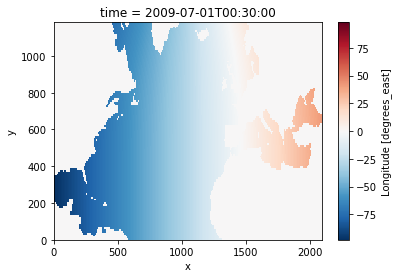

In [10]:
ds_plt.lon.plot()

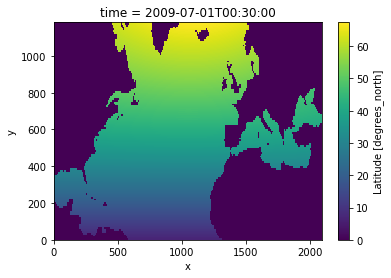

In [11]:
ds_plt.lat.plot()

In [12]:
lon = ds.lon.where(ds.lon != 0.)
lon.isel(x=0).max().values, lon.isel(x=-1).min().values

(array(-97.875, dtype=float32), array(41.743244, dtype=float32))

In [13]:
lat = ds.lat.where(ds.lat != 0.)
lat.isel(y=0).max().values, lat.isel(y=-1).min().values

(array(6.3370404, dtype=float32), array(62.321877, dtype=float32))

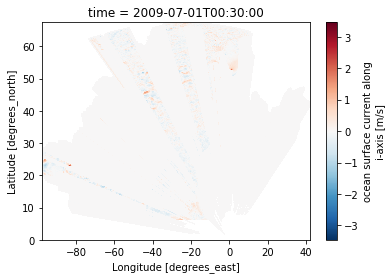

In [15]:
ds_plt.SSU.plot(x='lon',y='lat')

---

## start spectral calculation

In [16]:
# utility functions in order to compute frequency spectra
def _get_E(x, ufunc=True, **kwargs):
    ax = -1 if ufunc else 0
    #
    dkwargs = {'window': 'hann', 'return_onesided': False, 
               'detrend': 'linear', 'scaling': 'density'}
    dkwargs.update(kwargs)
    # 50% overlap by default
    f, E = welch(x, fs=24., axis=ax, **dkwargs)
    #
    if ufunc:
        return E
    else:
        return f, E

def get_E(v, f=None, **kwargs):
    v = v.chunk({'time': len(v.time)})
    if 'nperseg' in kwargs:
        Nb = kwargs['nperseg']
    else:
        Nb = 60*24
        kwargs['nperseg']= Nb
    if f is None:
        f, E = _get_E(v.values, ufunc=False, **kwargs)
        return f, E
    else:
        E = xr.apply_ufunc(_get_E, v,
                    dask='parallelized', output_dtypes=[np.float64],
                    input_core_dims=[['time']],
                    output_core_dims=[['freq_time']],
                    output_sizes={'freq_time': Nb}, kwargs=kwargs)
        return E.assign_coords(freq_time=f).sortby('freq_time')

In [17]:
ds = ds0

In [18]:
# generate a complex vector variable
ds['SSUV'] = ds['SSU'].fillna(0.) + 1j * ds['SSV'].fillna(0.)
ds = ds.drop(['SSU','SSV'])
#ds = ds.chunk({'time': len(ds.time)})

# should show the size of the dataset to know if we can load it in memory
print('dataset size: %.1f GB' %(ds.nbytes / 1e9))

dataset size: 2768.9 GB


In [ ]:
# spatial strides for decimation
dij=2 # 2 should fit
#overwrite=False

# spatial subsetting
#ds = ds0.isel(x=slice(0,None,dij), y=slice(0,None,dij)).chunk({'time': len(ds.time)})
ds = ds.isel(x=slice(0,None,dij), y=slice(0,None,dij))
ds = ds.persist()

In [ ]:
#ds = ds.chunk({'time': None})

In [ ]:
ds = ds.persist()

In [16]:

# generate a complex vector variable
ds['SSUV'] = ds['SSU'].fillna(0.) + 1j * ds['SSV'].fillna(0.)
ds = ds.drop(['SSU','SSV'])
#ds = ds.chunk({'time': len(ds.time)})

# should show the size of the dataset to know if we can load it in memory
print('dataset size: %.1f GB' %(ds.nbytes / 1e9))

dataset size: 2768.9 GB


In [ ]:
#ds = ds.persist()

In [ ]:
# spectral computation
# need to run once to get frequency line
f, E = get_E(ds['SSUV'].isel(x=2,y=2))
#
E = get_E(ds['SSUV'], f=f)

# store
E = E.to_dataset()
if not os.path.isdir(Efile) or overwrite:
    %time E.to_zarr(Efile, mode='w')
    print('--- done')
else:
    print('--- allready computed')
                

---

In [17]:
w = cluster.scale_up(30)

In [ ]:
client.restart()

In [29]:
cluster.close()